In [1]:
import iris
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import iris.quickplot as qplt
import matplotlib as mpl
import itertools
import pandas as pd

In [2]:
dir_vol = '/data/NAS-ph290/ph290/cmip5/volcello/'
#volcello_fx_ACCESS1-0_historical_r0i0p0.nc
dir_alk = '/data/BatCaveNAS/ph290/noc_talk/'
#talk_Oyr_HadGEM2-ES_rcp85_r1i1p1_2006-2099.nc

In [3]:

def model_names(directory,file_name_format,name_possition):
        files = glob.glob(directory+file_name_format)
        models_tmp = []
        for file in files:
                statinfo = os.stat(file)
                if statinfo.st_size >= 1:
                        models_tmp.append(file.split('/')[-1].split('_')[name_possition])
                        models = np.unique(models_tmp)
        return models



due to a issue with how I've compiled stuff (hdf libraries), I had to do GLODAP on JASMIN like:
cdo vertmean -fldmean -timmean -selvar,TAlk GLODAPv2.2016b.TAlk.nc GLODAPv2.2016b.TAlk_glob_mean.nc
result in:
/data/NAS-ph290/ph290/misc_data/GLODAPv2.2016b.TAlk_glob_mean.nc
mean is (2332.27280205/1.0e3)*1.026
GLODAP = mole equivalent per unit mass
CMIP5 = mole_equivalent / (mol m-3))*1.026
so glodap mean is 2.3929118949033


In [4]:
m1 = model_names(dir_vol,'volcello_fx_*_historical_r0i0p0.nc',2)
m2 = model_names(dir_alk,'talk_Oyr_*_rcp85_r1i1p1_*.nc',2)
models = list(set(m1).intersection(m2))

In [5]:
my_dict = {}

for model in models:
    vol_cube = iris.load_cube(dir_vol+'volcello_fx_'+model+'_historical_r0i0p0.nc','ocean_volume')
    alk_files = glob.glob(dir_alk+'talk_Oyr_'+model+'_rcp85_r1i1p1_*.nc')
    alk_cube = iris.load_cube(alk_files[0],'sea_water_alkalinity_expressed_as_mole_equivalent')[0] # m-3
    vol_cube.data.mask = alk_cube.data.mask
    total_volume = np.ma.sum(vol_cube.data)
#     if 1.2e+18 < total_volume < 1.4e+18: #i.e. only look at the models where I know I am correctly calculating the volume
    my_dict[model] = {}
    total_alk = np.ma.sum(vol_cube.data * alk_cube.data)
    my_dict[model]['total_alk'] = total_alk
    my_dict[model]['mean_alk'] = total_alk/total_volume
    my_dict[model]['total_volume'] = total_volume

df = pd.DataFrame.from_dict(my_dict)


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2030: UserWarning: Gracefully filling 'i' dimension coordinate masked points
  warnings.warn(msg.format(str(cf_coord_var.cf_name)))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2030: UserWarning: Gracefully filling 'j' dimension coordinate masked points
  warnings.warn(msg.format(str(cf_coord_var.cf_name)))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2030: UserWarning: Gracefully filling 'lev' dimension coordinate masked points
  warnings.warn(msg.format(str(cf_coord_var.cf_name)))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2037: UserWarning: Gracefully filling 'lev' dimension coordinate masked bounds
  warnings.warn(msg.format(str(cf_coord_var.cf_name)))
/home/ph290/anaconda2/lib/py

In [6]:
t_alk_file = '/data/NAS-geo01/ph290/observations/glodap_v1/Alkalinity_glob_tot.nc'
glodap_v1_t_alk_cube = (iris.load_cube(t_alk_file)[0,0]/1.0e3)*1.026
p_alk_file = '/data/NAS-geo01/ph290/observations/glodap_v1/PAlk_glob_tot.nc'
glodap_v1_p_alk_cube = (iris.load_cube(p_alk_file)[0,0]/1.0e3)*1.026



/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1935: UserWarning: Ignoring netCDF variable u'Alk' invalid units u'UMOL/KG'
  warnings.warn(msg.encode('ascii', errors='backslashreplace'))


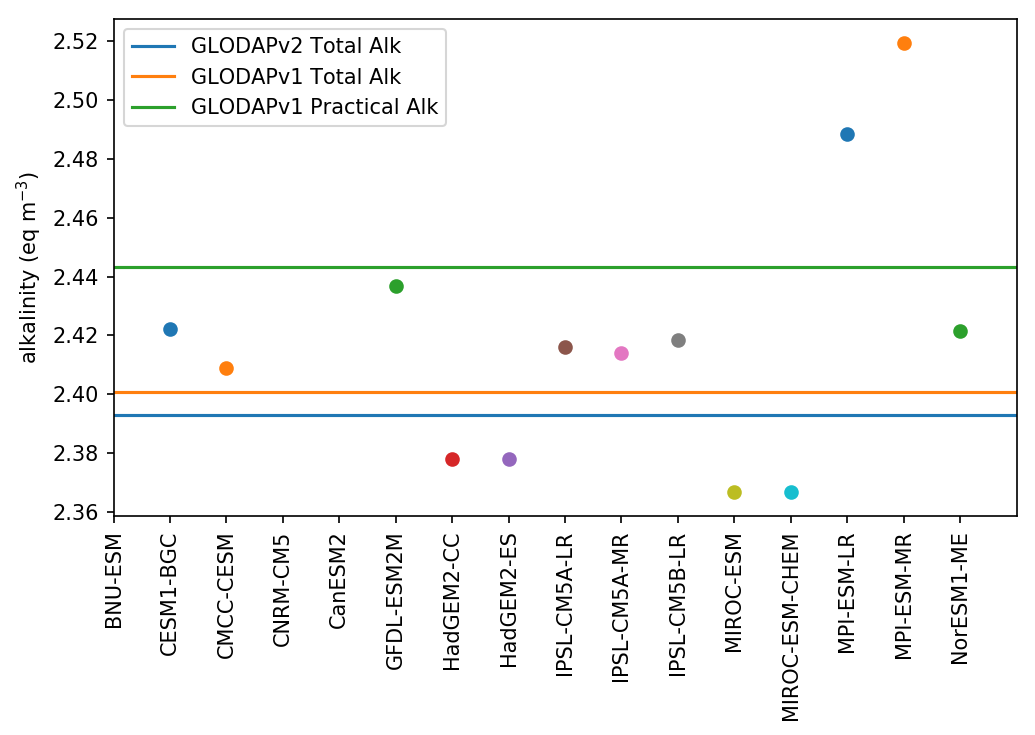

In [7]:
plt.figure(num=None, figsize=(7, 5), dpi=150, facecolor='none', edgecolor='none')


for i,item in enumerate(list(df)):
    if df[item].total_volume < 1.0e20:
        plt.scatter(i,df[item].mean_alk)

plt.plot([0,100],[2.3929118949033,2.3929118949033],label='GLODAPv2 Total Alk')
plt.plot([0,100],[glodap_v1_t_alk_cube.data,glodap_v1_t_alk_cube.data],label='GLODAPv1 Total Alk')
plt.plot([0,100],[glodap_v1_p_alk_cube.data,glodap_v1_p_alk_cube.data],label='GLODAPv1 Practical Alk')
plt.xticks(range(len(list(df))), list(df), rotation='vertical')
plt.xlim([0,len(list(df))])
plt.legend()
plt.ylabel('alkalinity (eq m$^{-3}$)')
plt.tight_layout()
plt.savefig('./figures/global_alkalinity.png')

The total alkalinity (TA) of seawater may be defined as the charge difference between the major conservative (concentration unaffected by changes in pH, pressure, or temperature) cations and anions:
(14)
The small excess positive charge (~ 2 as compared with ~ 600 mmol kg− 1 total positive charge concentration) is balanced by contributions from carbonate, borate, and water alkalinities (Fig. 4):

where PA is the practical alkalinity (alkalinity for most practical purposes). In fact, carbonate alkalinity (CA) is by far the most important contributor to TA, which leads to a useful approximation:

<img src="https://ars.els-cdn.com/content/image/3-s2.0-B9780124095489097177-eq09717-14-9780124095489.gif">

The small excess positive charge (~ 2 as compared with ~ 600 mmol kg− 1 total positive charge concentration) is balanced by contributions from carbonate, borate, and water alkalinities (Fig. 4)

<img src="https://ars.els-cdn.com/content/image/3-s2.0-B9780124095489097177-f09717-04-9780124095489.jpg">

<img src="https://ars.els-cdn.com/content/image/3-s2.0-B9780124095489097177-eq09717-15-9780124095489.gif">


<img src="https://ars.els-cdn.com/content/image/3-s2.0-B9780124095489097177-eq09717-16-9780124095489.gif">

Barker Dissolution of Deep Sea Carbonates 2016

In [8]:
my_dict_profile = {}
# models.remove('MIROC-ESM')

for model in models:
    print model
    vol_cube = iris.load_cube(dir_vol+'volcello_fx_'+model+'_historical_r0i0p0.nc','ocean_volume')
    alk_files = glob.glob(dir_alk+'talk_Oyr_'+model+'_rcp85_r1i1p1_*.nc')
    alk_cube = iris.load_cube(alk_files[0],'sea_water_alkalinity_expressed_as_mole_equivalent')[0] # m-3
    vol_cube.data.mask = alk_cube.data.mask
    total_volume = np.ma.sum(vol_cube.data,axis=1)
    total_volume = np.ma.sum(total_volume,axis=1)
#     if 1.2e+18 < total_volume < 1.4e+18: #i.e. only look at the models where I know I am correctly calculating the volume
    my_dict_profile[model] = {}
    total_alk = np.ma.sum(vol_cube.data * alk_cube.data,axis=1)
    total_alk = np.ma.sum(total_alk,axis=1)
    my_dict_profile[model]['total_alk'] = total_alk
    my_dict_profile[model]['mean_alk'] = total_alk/total_volume
    my_dict_profile[model]['total_volume'] = total_volume
    print vol_cube.coords
    name = vol_cube.coords(dimensions=0).pop().standard_name
    if not(name):
        name = vol_cube.coords(dimensions=0).pop().long_name
    my_dict_profile[model]['depths'] = vol_cube.coord(name).points

df_profile = pd.DataFrame.from_dict(my_dict_profile)



IPSL-CM5A-LR
<bound method Cube.coords of <iris 'Cube' of ocean_volume / (m3) (depth: 31; cell index along second dimension: 149; cell index along first dimension: 182)>>
MPI-ESM-LR
<bound method Cube.coords of <iris 'Cube' of ocean_volume / (m3) (depth: 40; cell index along second dimension: 220; cell index along first dimension: 256)>>
MIROC-ESM
<bound method Cube.coords of <iris 'Cube' of ocean_volume / (m3) (ocean sigma over z coordinate: 44; latitude: 192; longitude: 256)>>
CNRM-CM5
<bound method Cube.coords of <iris 'Cube' of ocean_volume / (m3) (depth: 42; cell index along second dimension: 292; cell index along first dimension: 362)>>
CanESM2
<bound method Cube.coords of <iris 'Cube' of ocean_volume / (m3) (depth: 40; latitude: 192; longitude: 256)>>
MIROC-ESM-CHEM
<bound method Cube.coords of <iris 'Cube' of ocean_volume / (m3) (ocean sigma over z coordinate: 44; latitude: 192; longitude: 256)>>
BNU-ESM
<bound method Cube.coords of <iris 'Cube' of ocean_volume / (m3) (generic 

none to remove
none to remove
none to remove
IPSL-CM5A-LR
MPI-ESM-LR
MIROC-ESM
MIROC-ESM-CHEM
IPSL-CM5B-LR
NorESM1-ME
HadGEM2-ES
HadGEM2-CC
CMCC-CESM
MPI-ESM-MR
GFDL-ESM2M
IPSL-CM5A-MR
CESM1-BGC


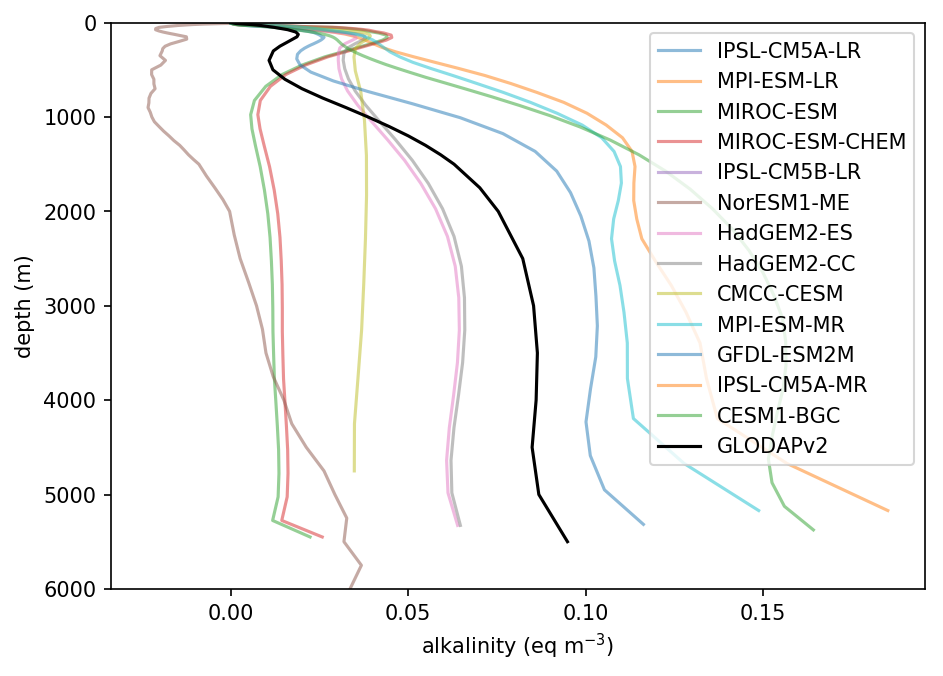

In [18]:
plt.figure(num=None, figsize=(7, 5), dpi=150, facecolor='none', edgecolor='none')

models = list(models)
try:
    models.remove('BNU-ESM')
except:
    print 'none to remove'
try:
    models.remove('CanESM2')
except:
    print 'none to remove'
try:
    models.remove('CNRM-CM5')
except:
    print 'none to remove'

for i,model in enumerate(models):
    print model
#     print np.shape(my_dict_profile[model]['depths'])
    model_alk =df_profile[model].mean_alk
    loc = np.where(df_profile[model]['depths'] == np.min(df_profile[model]['depths']))[0]
#     print loc
    plt.plot(model_alk - model_alk[loc], df_profile[model]['depths'],alpha=0.5,label=model)


glodap_v2_profile = iris.load_cube('/data/NAS-ph290/ph290/misc_data/GLODAPv2.2016b.TAlk_glob_mean_levels.nc')
glodap_depths = [   0.,   10.,   20.,   30.,   50.,   75.,  100.,  125.,  150.,        200.,  250.,  300.,  400.,  500.,  600.,  700.,  800.,  900.,       1000., 1100., 1200., 1300., 1400., 1500., 1750., 2000., 2500.,       3000., 3500., 4000., 4500., 5000., 5500.]
glodap_alk = glodap_v2_profile[:,0,0].data/1026.0
plt.plot(glodap_alk - glodap_alk[0],glodap_depths,'k',label='GLODAPv2')

plt.xlabel('alkalinity (eq m$^{-3}$)')
plt.ylabel('depth (m)')
plt.ylim([6000,0])
# plt.xlim([2.1,2.6])
plt.legend()
plt.savefig('./figures/global_alkalinity_profiles.png')

In [10]:
vol_cube = iris.load_cube(dir_vol+'volcello_fx_'+'MIROC-ESM'+'_historical_r0i0p0.nc','ocean_volume')

In [11]:
vol_cube.coords

<bound method Cube.coords of <iris 'Cube' of ocean_volume / (m3) (ocean sigma over z coordinate: 44; latitude: 192; longitude: 256)>>

In [12]:
name = vol_cube.coords(dimensions=0).pop().standard_name
if not(name):
    name = vol_cube.coords(dimensions=0).pop().long_name

In [13]:
vol_cube.coord(name).points

masked_array(data=[2.500e+00, 7.500e+00, 1.250e+01, 1.750e+01, 2.250e+01,
                   2.750e+01, 3.375e+01, 4.125e+01, 5.000e+01, 6.000e+01,
                   7.000e+01, 8.000e+01, 9.250e+01, 1.100e+02, 1.325e+02,
                   1.575e+02, 1.850e+02, 2.250e+02, 2.875e+02, 3.625e+02,
                   4.500e+02, 5.500e+02, 6.750e+02, 8.250e+02, 9.750e+02,
                   1.125e+03, 1.300e+03, 1.525e+03, 1.775e+03, 2.025e+03,
                   2.275e+03, 2.525e+03, 2.775e+03, 3.025e+03, 3.275e+03,
                   3.525e+03, 3.775e+03, 4.025e+03, 4.275e+03, 4.525e+03,
                   4.775e+03, 5.025e+03, 5.275e+03, 5.450e+03],
             mask=False,
       fill_value=1e+20)

none to remove
none to remove
none to remove
IPSL-CM5A-LR
MPI-ESM-LR
MIROC-ESM
MIROC-ESM-CHEM
IPSL-CM5B-LR
NorESM1-ME
HadGEM2-ES
HadGEM2-CC
CMCC-CESM
MPI-ESM-MR
GFDL-ESM2M
IPSL-CM5A-MR
CESM1-BGC


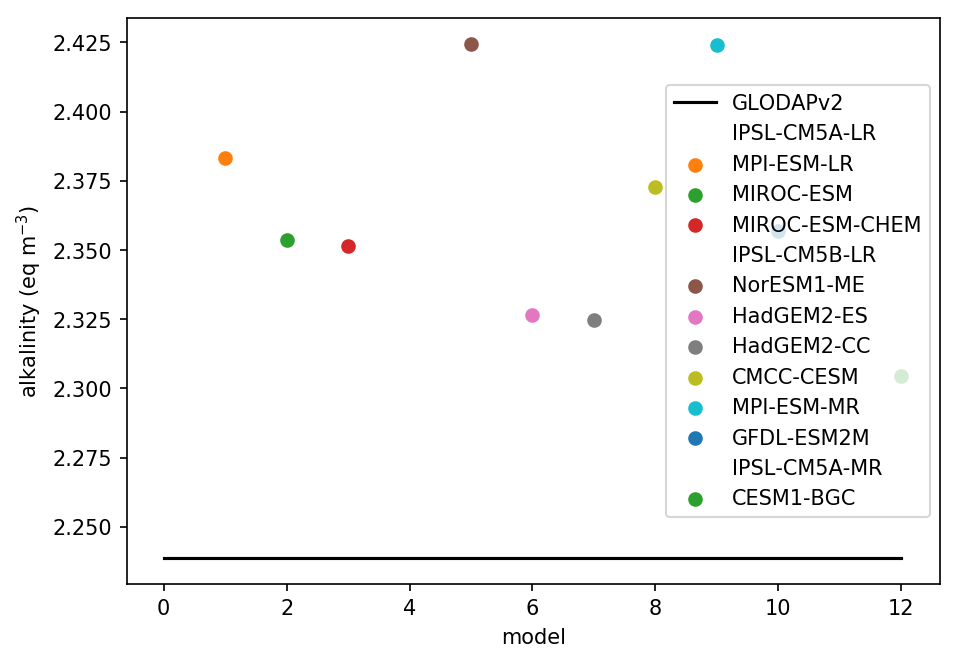

In [17]:
plt.figure(num=None, figsize=(7, 5), dpi=150, facecolor='none', edgecolor='none')

models = list(models)
try:
    models.remove('BNU-ESM')
except:
    print 'none to remove'
try:
    models.remove('CanESM2')
except:
    print 'none to remove'
try:
    models.remove('CNRM-CM5')
except:
    print 'none to remove'

for i,model in enumerate(models):
    print model
#     print np.shape(my_dict_profile[model]['depths'])
    model_alk =df_profile[model].mean_alk
    loc = np.where(df_profile[model]['depths'] == np.min(df_profile[model]['depths']))[0]
#     print loc
    plt.scatter(i,model_alk[loc],label=model)


glodap_v2_profile = iris.load_cube('/data/NAS-ph290/ph290/misc_data/GLODAPv2.2016b.TAlk_glob_mean_levels.nc')
glodap_depths = [   0.,   10.,   20.,   30.,   50.,   75.,  100.,  125.,  150.,        200.,  250.,  300.,  400.,  500.,  600.,  700.,  800.,  900.,       1000., 1100., 1200., 1300., 1400., 1500., 1750., 2000., 2500.,       3000., 3500., 4000., 4500., 5000., 5500.]
glodap_alk = glodap_v2_profile[:,0,0].data/1026.0
plt.plot([0,12],[glodap_alk[0],glodap_alk[0]],'k',label='GLODAPv2')
    
# plt.ylim([6000,0])
# plt.xlim([2.1,2.6])
plt.ylabel('alkalinity (eq m$^{-3}$)')
plt.xlabel('model')
plt.legend()

plt.savefig('./figures/global_alkalinity_surface.png')